In [8]:
""" Program to check that all necessary operators are in QASM files.
we compute coefficients using trace
and compare the output with given circuit.

As the result we know that all necessary operators are in QASM files.
"""

import math
from icecream import ic
import qiskit_qasm2
from qiskit_qasm2 import load, CustomClassical
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.linalg import expm
from numpy.linalg import norm, matrix_power
from functools import reduce
from itertools import product
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from matplotlib.ticker import MaxNLocator
import time

from os import listdir
from os.path import isfile, join

PAULIS = {'I': np.eye(2, dtype='complex'),
          'X': np.array([[0, 1], [1, 0]], dtype='complex'),
          'Y': np.array([[0, -1j], [1j, 0]]),
          'Z': np.diag(np.array([1, -1], dtype='complex'))}


def speed_multiple(b,c_map):
    """Multiply each column of a matrix by given constant."""
    for j, c in enumerate(c_map):
        b[:,j] *= c
    return b

## for higher order the coefficients are of order 10^24/10^28
B_sign = {3: (np.array([-1,0,1]),2),
          5: (np.array([1,-8,0,8,-1]),12),
          7: (np.array([-1,9,-45,0,45,-9,1]),60),
          9: (np.array([3,-32,168,-672,0,672,-168,32,-3]),840),
          11: (np.array([-2,25,-150,600,-2100,0,2100,-600,150,-25,2]),2520)}

def make_B(N, coefs, cbase):
    """ make matrix B s.t. L = -BB.T with correct zero boundary conditions.
    N - size of B.
    coefs - list of coefficients.
    cbase - divider.
    
    """
    B = np.zeros((N,N))
    l = len(coefs)//2
    diags = list(range(-l,l+1))
    for i,val in zip(diags,coefs):
        B += val*np.eye(N,k=i)

    ### Boundary connditions
    ## left side
    B[0,:] = np.zeros_like(B[0,:])
    B[:,0] = np.zeros_like(B[:,0])
    
    for i in range(l):
        coef_temp = coefs[-(i+1):]
        B[l-i,:len(coef_temp)] = B[l-i,:len(coef_temp)] - coef_temp
        # print(l-i, coef_temp)
    B[:,0] = B[:,0]*np.sqrt(2)

    ## right side
    B[-1,:] = np.zeros_like(B[-1,:])
    B[:,-1] = np.zeros_like(B[:,-1])
    for i in range(l):
        coef_temp = coefs[:(i+1)]
        B[-(l-i)-1,-len(coef_temp):] = B[-(l-i)-1,-len(coef_temp):] - coef_temp
        # print(-(l-i)-1, coef_temp)
    B[:,-1] = B[:,-1]*np.sqrt(2)
    
    # return B
    return B/cbase

def W(gr, wl, cb):
    p_str = w_coef_dict[(gr, wl, cb)]
    P = reduce(np.kron, [PAULIS[s] for s in p_str])
    alpha_trace = np.trace(H@P)/(2**NQ) # compute coefficient as inner product
    assert alpha_trace.imag == 0
    alpha_trace = alpha_trace.real
    weights_from_func_W.append(alpha_trace)
    return 2*alpha_trace*t

customs = [
    CustomClassical("w", 3, W),
]

In [9]:
"""Parameters"""

acc_order = 6 # to take files from SAMPLEOUT-{acc_order}

l = 2
t = 0.7
c_max = 1

NQ = 4
nq = NQ - 1

x_real = np.linspace(0,l,2**(nq))
dx = x_real[1]-x_real[0]

c_map = [c_max]*(2**nq) # np.random.rand(2**nq)*c_max
# c_map = np.random.rand(2**nq)*c_max

"""Manual generation of desired B, H, exp(-iHt/dx)"""
coef_B,cb_B = B_sign[7]
B = make_B(2**(nq),coef_B,cb_B)

assert len(x_real) == B.shape[0]

B = speed_multiple(B, c_map)

H = np.block([[np.zeros_like(B), B],[B.T, np.zeros_like(B)]])

exp_H = expm(-1j*H*t/dx)

print(np.round(B*cb_B,1))

[[  0.    0.    0.    0.    0.    0.    0.    0. ]
 [-63.6   9.   44.   -9.    1.    0.    0.    0. ]
 [ 12.7 -46.    0.   45.   -9.    1.    0.    0. ]
 [ -1.4   9.  -45.    0.   45.   -9.    1.    0. ]
 [  0.   -1.    9.  -45.    0.   45.   -9.    1.4]
 [  0.    0.   -1.    9.  -45.    0.   46.  -12.7]
 [  0.    0.    0.   -1.    9.  -44.   -9.   63.6]
 [  0.    0.    0.    0.    0.    0.    0.    0. ]]


In [10]:
"""Reading QASM files"""

ic.disable()

mypath = 'SAMPLEOUT-{}'.format(acc_order)
file_names = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f)) and '-{}_{}_'.format(acc_order,NQ) in f]
dict_sets = dict(zip(range(len(file_names)),file_names))


H_rec = 0j
for filename in file_names:
    """Read Pauli strings and coefficients (signs) from file """
    p_str_list = []
    p_str_list_diag = []
    w_coef_dict = {}

    with open(filename) as f:
        counter = 0 # to count lines starting with //
        for line in f:
            line = line.strip()
            if 'Differential coefficients' in line:
                counter = 1

            if counter == 1: # diagonal part (Rz)
                if 'rz(' in line:
                    temp = line.split()[2] # //XIII,+ZIII
                    p_str_d = temp[-NQ-1:] # e.g. +IZIZI
                    p_str = temp[2:NQ+2] # e.g. XYXYX

                    temp = line.split()[0]
                    w_coef = tuple([int(i) for i in temp[5:-2].split(',')])# e.g. (10,2,60)

                    p_str_list.append(p_str)
                    p_str_list_diag.append(p_str_d)
                    w_coef_dict[w_coef] = p_str
    
    """Read circuit from QASM file """
    
    weights_from_func_W = []
    # print(filename, 't = {}'.format(t))
    circuit_l = load(filename, custom_classical=customs).reverse_bits()
    matrix_l = qi.Operator(circuit_l).data

    ic(filename, p_str_list, p_str_list_diag, weights_from_func_W, w_coef_dict)

    """Compare results"""
    
    H_group = 0j # reconstructed Hamiltonian (sum of alpha_j P_j)
    # expm_prod = np.eye(2**NQ) # One step in Trotter formula (Product of expm(-i t alpha_j P_j)
    sum_error_coef = 0
    
    for p_str, p_str_d, alpha_trace in zip(p_str_list,p_str_list_diag, weights_from_func_W):

        P = reduce(np.kron, [PAULIS[s] for s in p_str])
        H_group += alpha_trace*P
        
        # H_group += sign*wwH*P # resulted Hamiltonian, with weights computed in c programm
        # expm_prod = expm_prod@expm(-1j*sign*wwH*P*t) # resulted one step circuit, with weights computed in c programm
        # expm_prod = expm_prod@expm(-1j*alpha_trace*P*t) # resulted one step circuit, with weights computed as trace
    
    # exp_H_group = expm(-1j*H_group*t)
 
    H_rec += H_group
exp_H_rec = expm(-1j*H_rec*t/dx)
print('||H - H_rec|| =', norm(H - H_rec))
print('||exp_H - exp_H_rec|| =', norm(exp_H - exp_H_rec))

#     print('Sum of coefficients difference norm:', sum_error_coef)
#     print('Circuit: ||П expm(-1j*alpha*P*t) - circuit|| =', norm(expm_prod - matrix_l))
# #     print('Commutation: ||expm(-1j*H*t) - П expm(-1j*alpha*P*t)|| =', norm(exp_H_rec - expm_prod))
#     print('-------------------------------------------------------','\n')


ic.enable()

||H - H_rec|| = 1.4190843872370323e-16
||exp_H - exp_H_rec|| = 1.5135608984118127e-15


## Matrix visualisation

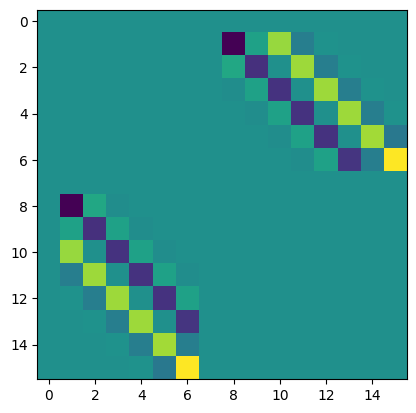

In [11]:
plt.imshow(H_rec.real)

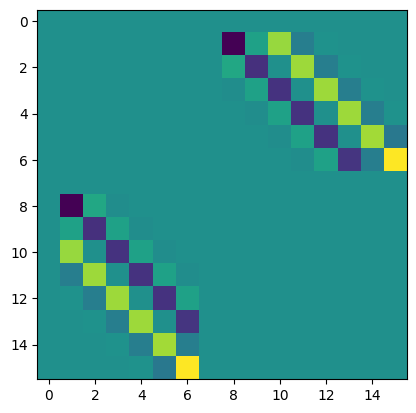

In [12]:
plt.imshow(H.real)

In [13]:
for i in H_rec*cb_B:
    print(' '.join(str(j) for j in np.round(i,1).real))

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -63.6 9.0 44.0 -9.0 1.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 12.7 -46.0 0.0 45.0 -9.0 1.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.4 9.0 -45.0 0.0 45.0 -9.0 1.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 9.0 -45.0 0.0 45.0 -9.0 1.4
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 9.0 -45.0 0.0 46.0 -12.7
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 9.0 -44.0 -9.0 63.6
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 -63.6 12.7 -1.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 9.0 -46.0 9.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
-0.0 44.0 0.0 -45.0 9.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 -9.0 45.0 0.0 -45.0 9.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 1.0 -9.0 45.0 0.0 -45.0 9.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 1.0 -9.0 45.0 0.0 -44.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 1.0 -9.0 46.0 -9.0 0.0 0.0 0.0 0.0 0

In [14]:
for i in H*cb_B:
    print(' '.join(str(j) for j in np.round(i,1).real))

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -63.6 9.0 44.0 -9.0 1.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 12.7 -46.0 0.0 45.0 -9.0 1.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.4 9.0 -45.0 0.0 45.0 -9.0 1.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 9.0 -45.0 0.0 45.0 -9.0 1.4
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 9.0 -45.0 0.0 46.0 -12.7
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 9.0 -44.0 -9.0 63.6
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 -63.6 12.7 -1.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 9.0 -46.0 9.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 44.0 0.0 -45.0 9.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 -9.0 45.0 0.0 -45.0 9.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 1.0 -9.0 45.0 0.0 -45.0 9.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 1.0 -9.0 45.0 0.0 -44.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 1.0 -9.0 46.0 -9.0 0.0 0.0 0.0 0.0 0.0